## Exercise Sheet 1: Recurrent Models

Compare Vanilla Recurrent Neural Networks (RNN) with Long-Short Term Networks (LSTM). Implement a vanilla RNN and LSTM from scratch.

In [1]:
import json
import os
import time
import math
import sys
import numpy as np
from numpy import sqrt
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.functional as F

# import RNN from torch
from torch.nn import RNN

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 5]

# set seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set paths
data_path = './data/'
model_path = './model/'
results_path = './results/'

# make directories if they don't exist
if not os.path.exists(data_path):
    os.makedirs(data_path)
if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(results_path):
    os.makedirs(results_path)


# Data
p1 = [5, 10, 15, 20]
p2_acc_rnn = []
p3_acc_lstm = []

# Hyperparameters
config = {
    "input_length": 12,
    "input_dim": 1,
    "num_classes": 10,
    "num_hidden": 128,
    "batch_size": 128,
    "rnn_learning_rate": 0.001,
    "lstm_learning_rate": 0.001,
    "train_steps": 10000,
    "test_steps": 100,
    "max_norm": 1.0
}

# save config
with open(model_path + 'config.json', 'w') as file:
    json.dump(config, file)

### Task 1: Toy Problem: Palindrome Numbers

Use a  a recurrent neural network to predict the next digit of the palindrome
at every timestep. This can become difficult for very long sequences since the network has to memorise information from very far away earlier timesteps. Goal is to study the memoization capability of recurrent networks.

In [2]:
class PalindromeDataset(data.Dataset):
    """ Randomly generates palindromes of a given length.
        The input is the first N-1 digits of the palindrome, the target is the last digit.
        For short palindromes, the number of possible palindromes is limited.
    """
    def __init__(self, seq_length):
        self.seq_length = seq_length

    def __len__(self):
        # Number of possible palindroms can be very big:
        # (10**(seq_length/2) or (10**((seq_length+1)/2)
        # Therefore we return the maximum integer value
        return sys.maxsize

    def __getitem__(self, idx):
        # Keep last digit as target label. Note: one-hot encoding for inputs is
        # more suitable for training, but this also works.
        full_palindrome = self.generate_palindrome()
        # Split palindrome into inputs (N-1 digits) and target (1 digit)
        return full_palindrome[0:-1], int(full_palindrome[-1])

    def generate_palindrome(self):
        # Generates a single, random palindrome number of 'length' digits.
        left = [np.random.randint(0, 10) for _ in range(math.ceil(self.seq_length / 2))]
        left = np.asarray(left, dtype=np.float32)
        right = np.flip(left, 0) if self.seq_length % 2 == 0 else np.flip(left[:-1], 0)
        return np.concatenate((left, right))


**Question 1.1: Backpropagation through Time**

Backpropagation by computing derivatives from $L_{t}$ with respect to $W_{ph}$

\begin{aligned}
\frac{\partial L_t}{\partial W_{ph}} = \frac{\partial L_t}{\partial h_t} \frac{\partial h_t}{\partial W_{ph}}
\end{aligned}


Backpropagation by computing derivatives from $L_{t}$ with respect to $W_{hh}$
\begin{aligned}
\frac{\partial L_{t}}{\partial W_{hh}} = \frac{\partial L_{t}}{\partial h_{t}} \frac{\partial h_{t}}{\partial h_{t-1} } \dots \frac{\partial h_{1}}{\partial W_{hh}} \\
= \frac{\partial L_{t}}{\partial h_{t}}(\prod_{t=2}^{T} \frac{\partial h_{t}}{\partial  h_{t-1}})\frac{\partial h_{1}}{\partial W_{hh}} \\
= \frac{\partial L_{t}}{\partial h_{t}}(\prod_{t=2}^{T}  softmax^{'}(W_{hh}h_{t-1} + W_{xh}x_t)W_{hh}^{T-1})\frac{\partial h_{1}}{\partial W_{hh}} \\
\end{aligned}

Difference in temporal dependence of both gradients in the first equation is noly on the current hidden state $h_t$, and not on the previous hidden states. The $softmax$ activated value will almost always be less than 1 because the activation is always between zero and one with a long tail on both ends. Thus, as the timestep $t$ gets larger (i.e. longer timesteps), the gradient will descrease in value due to the repeated multiplication and get close to zero. On the other side it can equally lead to exploding gradients if the values are very large.

**Question 1.2: Implement a Vanilla Recurrent Network**

In [3]:
class VanillaRNN(nn.Module):

    def __init__(
        self, seq_length, input_dim, num_hidden, num_classes, batch_size, device=None):
        super(VanillaRNN, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.batch_size = batch_size

        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.device = device

        # Define the RNN layer
        self.hidden_state = torch.zeros(self.batch_size, self.num_hidden)
        self.W_hx = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))      # input to hidden
        self.W_hh = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))     # hidden to hidden
        self.B_h = nn.Parameter(torch.Tensor(self.num_hidden))                       # hidden bias
        # Define the output layer
        self.W_ph = nn.Parameter(torch.Tensor(self.num_hidden, self.num_classes))    # hidden to output
        self.B_y = nn.Parameter(torch.Tensor(self.num_classes))                      # output bias

        # Initialize weights
        self.init_weights()

    def forward(self, x):
        # Initialize hidden state
        h_t = torch.zeros(self.num_hidden)

        for t in range(self.seq_length): # iterate over the time steps
            x_t = x[:, t].view(128,-1)
            h_t = torch.tanh(x_t @ self.W_hx + h_t @ self.W_hh + self.B_h)

        output = h_t @ self.W_ph + self.B_y
        y = torch.softmax(output, dim=1)
        return y

    def init_weights(self):
        """ Initialize weights to avoid gradients vanishing or exploding.
            Source: https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-2/

        """
        # Initialize weights with uniform distribution
        n_hx = self.W_hx.size(0)  # number of incoming connections for W_hx
        nn.init.uniform_(self.W_hx, -1 / sqrt(n_hx), 1 / sqrt(n_hx))

        n_hh = self.W_hh.size(0)  # number of incoming connections for W_hh
        nn.init.uniform_(self.W_hh, -1 / sqrt(n_hh), 1 / sqrt(n_hh))

        n_ph = self.W_ph.size(0)  # number of incoming connections for W_ph
        nn.init.uniform_(self.W_ph, -1 / sqrt(n_ph), 1 / sqrt(n_ph))

        # Initialize biases to zeros
        nn.init.zeros_(self.B_h)
        nn.init.zeros_(self.B_y)


    def set_grad(self, requires_grad):
        # Set requires_grad for all parameters
        for param in self.parameters():
            param.requires_grad = requires_grad

In [4]:
def compute_accuracy(outputs, targets):
    """ Compute the accuracy of the model's predictions."""
    # Compute accuracy of outputs compared to targets
    _, predicted = torch.max(outputs, 1)
    correct = predicted.eq(targets)
    return 100 * correct.sum().item() / targets.size(0)

In [5]:

def train(config:json, input_length=5, lr=0.001, step_size=1000, gamma=0.1, type='RNN', opt='Adam', device=None):
    """ Train the model on the training set.
        Returns the trained model, losses and accuracies.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if input_length == 0:
        input_length = config['input_length']

    # Initialize the model that we are going to use
    if type == 'RNN':
        model = VanillaRNN(input_length, config['input_dim'], config['num_hidden'], config['num_classes'], config['batch_size'])
    elif type == 'LSTM':
        model = LSTM(input_length, config['input_dim'], config['num_hidden'], config['num_classes'], config['batch_size'])
    else:
        raise ValueError('Model type not supported')

    model.to(device)
    model.train()

    # Initialize the dataset and data loader (note the +1)
    dataset = PalindromeDataset(input_length + 1)
    data_loader = data.DataLoader(dataset, config['batch_size'], num_workers=0)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()

    # Define optimizer
    if opt == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    else:
        raise ValueError('Optimizer not supported')

    # Train the model
    losses = []
    accuracies = []
    loss = 0.0

    for i, (inputs, targets) in enumerate(data_loader, 0):

        # Only for time measurement of step through network
        t1 = time.time()
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Update learning rate
        if opt == 'RMSprop':
            scheduler.step()

        # Forward pass, backward pass, and optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Clip gradients to prevent exploding gradients
        nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])

        loss += loss.item()
        accuracy = 0.0

        # Print statistics
        if i % 10 == 0:
            # Just for time measurement
            t2 = time.time()
            # print accuracy/loss here
            accuracy = compute_accuracy(outputs, targets)
            accuracies.append(accuracy)
            print('[step: %5d] loss: %.4f acc: %.4f time: %5d' %
                          (i, loss / 10, accuracy, t2-t1 / 10))
            losses.append(loss.detach().numpy() / 10)
            loss = 0.0

        if i == config['train_steps']:
            # If you receive a PyTorch data-loader error, check this bug report:
            # https://github.com/pytorch/pytorch/pull/9655
            break

    print('Finished Training')
    return model, losses, accuracies


def test(model, config:json, input_length=5, device=None):
    """ Test the model on the test set.
        Returns the accuracies.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if input_length == 0:
        input_length = config['input_length']

    # Initialize the dataset and data loader (leave the +1)
    dataset = PalindromeDataset(input_length+1)
    data_loader = data.DataLoader(dataset, config['batch_size'], num_workers=0)

    model.to(device)
    model.eval()

    # Test the model
    accuracies = []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader, 0):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            accuracy = 0.0
            if i % 10 == 0:
                accuracy = compute_accuracy(outputs, targets)
                accuracies.append(accuracy)
                print('Accuracy: %.4f' % accuracy)

            if i == config['test_steps']:
              # If you receive a PyTorch data-loader error, check this bug report:
              # https://github.com/pytorch/pytorch/pull/9655
              break

    print('Finished Testing')
    return accuracies


In [6]:
# Load the configuration
with open(model_path + 'config.json', 'r') as file:
    config = json.load(file)

In [7]:
def plot_loss(losses, title='Training Loss', path=None):
    """ Plot the losses of the model."""
    if path is None:
        path = results_path + 'training_loss.png'
    plt.figure(figsize=(6,4))
    plt.plot(losses)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title(title)
    plt.savefig(path)
    plt.show()

def plot_accuracy(accuracies, title='Training Accuracy', path=None):
    """ Plot the accuracies of the model."""
    if path is None:
        path = results_path + 'training_accuracy.png'
    plt.figure(figsize=(6,4))
    plt.plot(accuracies)
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.savefig(path)
    plt.show()


**Question 1.3: Train RNN with varying T for sequence lengths**

* Train and evaluate model on Palindromes with length N = 5

In [8]:
# Train the model on T=5
model, losses, accuracies = train(config, input_length=p1[0], lr=config['rnn_learning_rate'], type='RNN', device=device)

<ipython-input-5-0a8de5faed98>:64: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:     0] loss: 0.4603 acc: 11.7188 time: 1547371974
[step:    10] loss: 0.4605 acc: 10.9375 time: 1547371975
[step:    20] loss: 0.4599 acc: 10.9375 time: 1547371975
[step:    30] loss: 0.4598 acc: 13.2812 time: 1547371975
[step:    40] loss: 0.4618 acc: 7.0312 time: 1547371976
[step:    50] loss: 0.4607 acc: 7.8125 time: 1547371976
[step:    60] loss: 0.4608 acc: 11.7188 time: 1547371976
[step:    70] loss: 0.4578 acc: 15.6250 time: 1547371977
[step:    80] loss: 0.4564 acc: 19.5312 time: 1547371977
[step:    90] loss: 0.4496 acc: 20.3125 time: 1547371977
[step:   100] loss: 0.4408 acc: 21.0938 time: 1547371977
[step:   110] loss: 0.4450 acc: 18.7500 time: 1547371978
[step:   120] loss: 0.4385 acc: 24.2188 time: 1547371978
[step:   130] loss: 0.4372 acc: 21.8750 time: 1547371978
[step:   140] loss: 0.4353 acc: 28.9062 time: 1547371978
[step:   150] loss: 0.4429 acc: 20.3125 time: 1547371979
[step:   160] loss: 0.4263 acc: 32.8125 time: 1547371979
[step:   170] loss: 0.4157 acc: 3

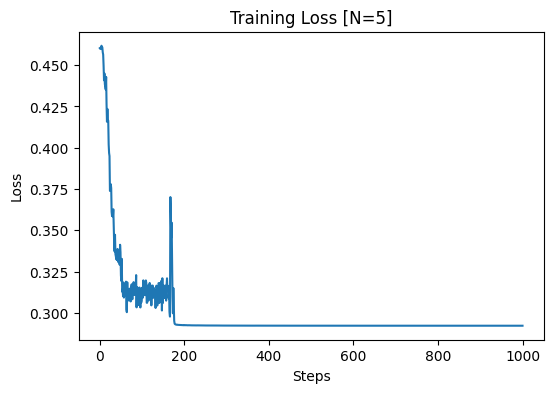

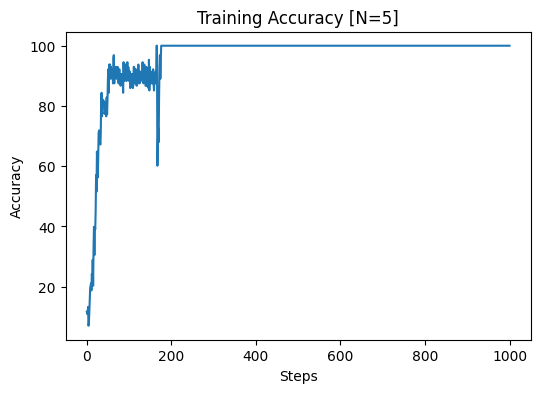

In [9]:
# Plot the losses
plot_loss(losses, title='Training Loss [N=5]', path=results_path + 'training_loss_5_rnn.png')

# Plot accuracies
plot_accuracy(accuracies, title='Training Accuracy [N=5]', path=results_path + 'training_accuracy_5_rnn.png')

In [10]:
# Test the model
test_accuracies = test(model, input_length=p1[0], config=config, device=device)

# Add accuracies
p2_acc_rnn.append(np.mean(test_accuracies))

Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Finished Testing


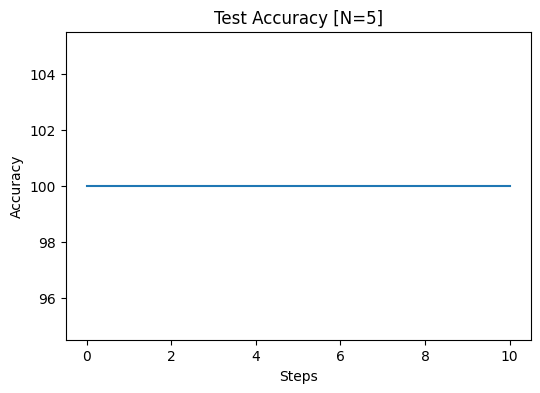

Average test accuracy: 100.00%


In [11]:
# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy [N=5]', path=results_path + 'test_accuracy_5_rnn.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

### Task 2: Vanilla RNN in PyTorch

In [12]:
# Train the model on T=10
model, losses, accuracies = train(config, input_length=p1[1], lr=config['rnn_learning_rate'], type='RNN', device=device)

[step:     0] loss: 0.4610 acc: 8.5938 time: 1547372059
[step:    10] loss: 0.4613 acc: 7.8125 time: 1547372060


<ipython-input-5-0a8de5faed98>:64: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:    20] loss: 0.4601 acc: 11.7188 time: 1547372060
[step:    30] loss: 0.4610 acc: 10.9375 time: 1547372060
[step:    40] loss: 0.4612 acc: 9.3750 time: 1547372060
[step:    50] loss: 0.4611 acc: 8.5938 time: 1547372060
[step:    60] loss: 0.4609 acc: 8.5938 time: 1547372060
[step:    70] loss: 0.4592 acc: 12.5000 time: 1547372060
[step:    80] loss: 0.4612 acc: 12.5000 time: 1547372060
[step:    90] loss: 0.4613 acc: 8.5938 time: 1547372060
[step:   100] loss: 0.4596 acc: 12.5000 time: 1547372060
[step:   110] loss: 0.4607 acc: 10.9375 time: 1547372061
[step:   120] loss: 0.4602 acc: 8.5938 time: 1547372061
[step:   130] loss: 0.4588 acc: 13.2812 time: 1547372061
[step:   140] loss: 0.4608 acc: 10.1562 time: 1547372061
[step:   150] loss: 0.4598 acc: 7.0312 time: 1547372061
[step:   160] loss: 0.4598 acc: 9.3750 time: 1547372061
[step:   170] loss: 0.4602 acc: 11.7188 time: 1547372061
[step:   180] loss: 0.4609 acc: 7.8125 time: 1547372061
[step:   190] loss: 0.4605 acc: 7.8125 

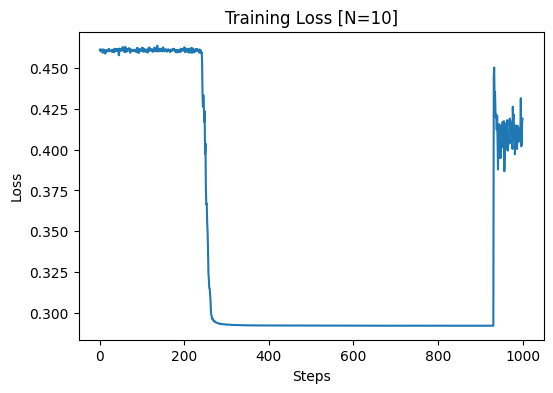

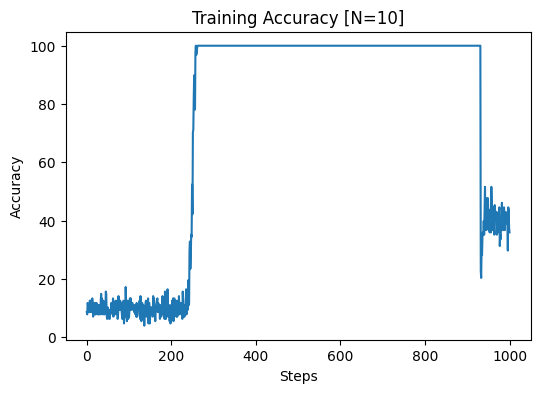

In [13]:
# Plot the losses
plot_loss(losses, title='Training Loss [N=10]', path=results_path + 'training_loss_10_rnn.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy [N=10]', path=results_path + 'training_accuracy_10_rnn.png')

In [14]:
# Test the model
test_accuracies = test(model, input_length=p1[1], config=config, device=device)

Accuracy: 39.8438
Accuracy: 37.5000
Accuracy: 45.3125
Accuracy: 39.0625
Accuracy: 39.8438
Accuracy: 32.0312
Accuracy: 32.0312
Accuracy: 35.1562
Accuracy: 42.1875
Accuracy: 38.2812
Accuracy: 35.1562
Finished Testing


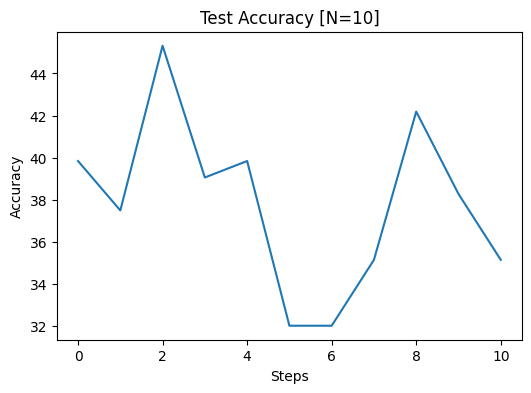

Average test accuracy: 37.86%


In [15]:
# Add accuracies
p2_acc_rnn.append(np.mean(test_accuracies))

# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy [N=10]', path=results_path + 'test_accuracy_10_rnn.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

[step:     0] loss: 0.4602 acc: 12.5000 time: 1547372181


<ipython-input-5-0a8de5faed98>:64: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:    10] loss: 0.4616 acc: 10.9375 time: 1547372181
[step:    20] loss: 0.4611 acc: 7.8125 time: 1547372181
[step:    30] loss: 0.4617 acc: 3.9062 time: 1547372182
[step:    40] loss: 0.4608 acc: 6.2500 time: 1547372182
[step:    50] loss: 0.4595 acc: 13.2812 time: 1547372182
[step:    60] loss: 0.4612 acc: 7.8125 time: 1547372182
[step:    70] loss: 0.4598 acc: 9.3750 time: 1547372182
[step:    80] loss: 0.4599 acc: 12.5000 time: 1547372182
[step:    90] loss: 0.4585 acc: 14.8438 time: 1547372183
[step:   100] loss: 0.4600 acc: 13.2812 time: 1547372183
[step:   110] loss: 0.4601 acc: 10.9375 time: 1547372183
[step:   120] loss: 0.4616 acc: 7.0312 time: 1547372183
[step:   130] loss: 0.4607 acc: 7.0312 time: 1547372183
[step:   140] loss: 0.4609 acc: 10.9375 time: 1547372183
[step:   150] loss: 0.4606 acc: 10.9375 time: 1547372183
[step:   160] loss: 0.4601 acc: 10.1562 time: 1547372184
[step:   170] loss: 0.4594 acc: 14.8438 time: 1547372184
[step:   180] loss: 0.4604 acc: 7.0312

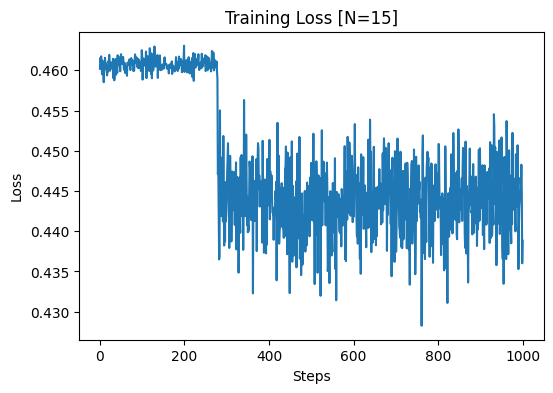

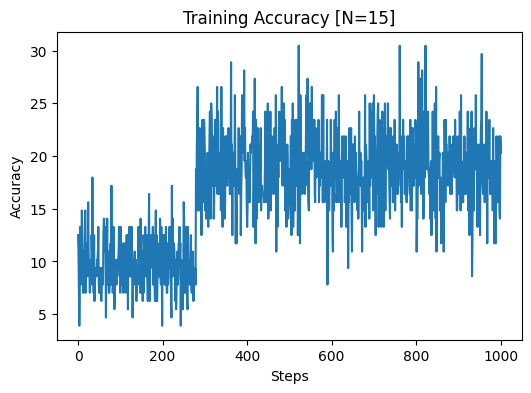

In [16]:
# Train the model on T=15
model, losses, accuracies = train(config, input_length=p1[2], lr=config['rnn_learning_rate'], type='RNN', device=device)

# Plot the losses
plot_loss(losses, title='Training Loss [N=15]', path=results_path + 'training_loss_15_rnn.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy [N=15]', path=results_path + 'training_accuracy_15_rnn.png')

In [17]:
# Test the model
test_accuracies = test(model, input_length=p1[2], config=config, device=device)

# Add accuracies
p2_acc_rnn.append(np.mean(test_accuracies))

Accuracy: 17.1875
Accuracy: 18.7500
Accuracy: 26.5625
Accuracy: 16.4062
Accuracy: 11.7188
Accuracy: 21.0938
Accuracy: 11.7188
Accuracy: 19.5312
Accuracy: 21.0938
Accuracy: 13.2812
Accuracy: 19.5312
Finished Testing


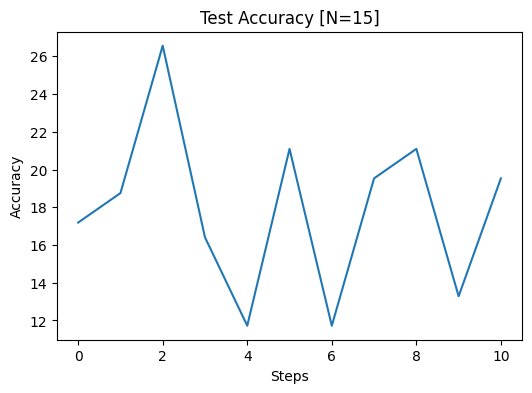

Average test accuracy: 17.90%


In [18]:
# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy [N=15]', path=results_path + 'test_accuracy_15_rnn.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

In [19]:
# Train the model on T=20
model, losses, accuracies = train(config, input_length=p1[3], lr=config['rnn_learning_rate'], type='RNN', device=device)

[step:     0] loss: 0.4624 acc: 8.5938 time: 1547372337


<ipython-input-5-0a8de5faed98>:64: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:    10] loss: 0.4606 acc: 11.7188 time: 1547372337
[step:    20] loss: 0.4609 acc: 10.1562 time: 1547372337
[step:    30] loss: 0.4612 acc: 7.8125 time: 1547372337
[step:    40] loss: 0.4603 acc: 10.1562 time: 1547372338
[step:    50] loss: 0.4624 acc: 10.9375 time: 1547372338
[step:    60] loss: 0.4617 acc: 9.3750 time: 1547372338
[step:    70] loss: 0.4610 acc: 10.1562 time: 1547372338
[step:    80] loss: 0.4595 acc: 14.8438 time: 1547372338
[step:    90] loss: 0.4612 acc: 10.1562 time: 1547372338
[step:   100] loss: 0.4617 acc: 4.6875 time: 1547372339
[step:   110] loss: 0.4610 acc: 10.1562 time: 1547372339
[step:   120] loss: 0.4603 acc: 10.1562 time: 1547372339
[step:   130] loss: 0.4599 acc: 12.5000 time: 1547372339
[step:   140] loss: 0.4603 acc: 12.5000 time: 1547372339
[step:   150] loss: 0.4607 acc: 6.2500 time: 1547372340
[step:   160] loss: 0.4603 acc: 9.3750 time: 1547372340
[step:   170] loss: 0.4596 acc: 13.2812 time: 1547372340
[step:   180] loss: 0.4620 acc: 7.03

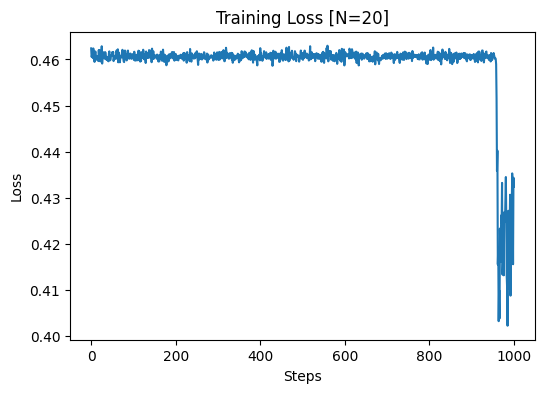

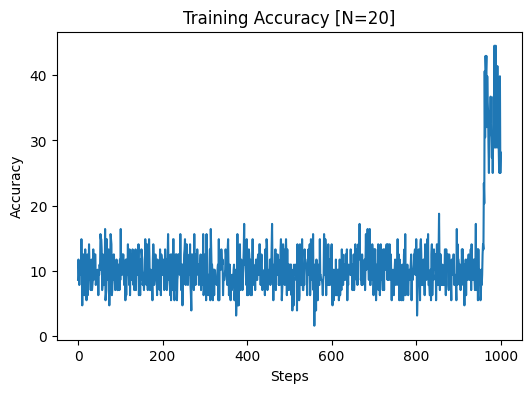

In [20]:
# Plot the losses
plot_loss(losses, title='Training Loss [N=20]', path=results_path + 'training_loss_20_rnn.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy [N=20]', path=results_path + 'training_accuracy_20_rnn.png')

In [21]:
# Test the model
test_accuracies = test(model, input_length=p1[3], config=config, device=device)

# Add accuracies
p2_acc_rnn.append(np.mean(test_accuracies))

Accuracy: 25.7812
Accuracy: 16.4062
Accuracy: 25.7812
Accuracy: 22.6562
Accuracy: 19.5312
Accuracy: 17.1875
Accuracy: 21.0938
Accuracy: 24.2188
Accuracy: 18.7500
Accuracy: 29.6875
Accuracy: 26.5625
Finished Testing


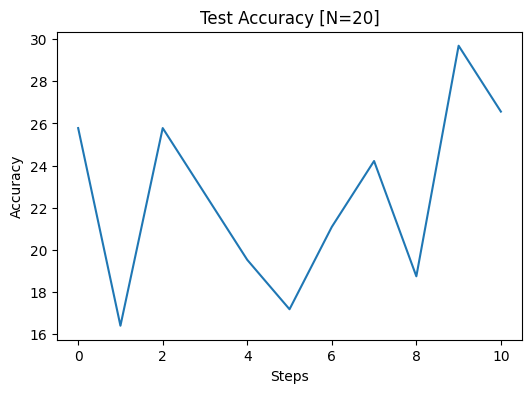

Average test accuracy: 22.51%


In [22]:
# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy [N=20]', path=results_path + 'test_accuracy_20_rnn.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

**Question 1.4: Optimization Methods (momentum, adaptive learning rate)**

Vanilla Gradient Descent computes gradients of loss function with respect to the model weights and updates them which can make the loss function slowly oscillate towards vertical axes. This happens since no history about the previously computed gradients are kept track off, making the gradient steps less deterministic at each step, which can lead to a slower convergence. Due to this osicllation a large learning rate could lead to disconvergence.

Hence, to achieve faster and more stable convergence, it would be desirable for the loss function to take larger steps in the horizontal direction while taking smaller steps in the vertical direction. Momentum is a technique used to accomplish this. It incorporates an exponentially weighted moving average of the gradient values, which helps the optimizer maintain a consistent direction in the parameter space. By doing so, the momentum term increases for dimensions whose gradients point in the same directions, while reducing updates for dimensions whose gradients frequently change directions. Consequently, this results in faster convergence and reduced oscillation.

*Adam Optimizer*

Adam is an _adaptive learningrate_ optimization algorithm that combines the ideas from RMSprop and Stochastic Gradient Descent with momentum. It utilizes the squared gradients to scale the learning rate, similar to RMSprop, and employs a moving average of the gradients instead of the gradients themselves, like momentum. This combination of techniques allows Adam to adapt the learning rate for each parameter individually, leading to more efficient optimization and faster convergence in many cases.

\begin{aligned}
m_t & = \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t & = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{m}_t & = \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t & = \frac{v_t}{1 - \beta_2^t} \\
\theta_t & = \theta_{t-1} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{aligned}


- $m\_t$ and $v\_t$ represent the first moment (mean) and second moment (uncentered variance) estimates, respectively.
- $ß\_1$ and $ß\_2$ are the exponential decay rates for the moment estimates.
- $g\_t$ denotes the gradient at time step $t$.
- $\hat{m}\_t$ and $\hat{v}\_t$ are the bias-corrected first moment and second moment estimates, respectively. The bias correction is applied to counteract the effect of initialization on the moment estimates.
- The term $1 - \beta\_1^t$ and $1 - \beta\_2^t$ in the denominators of $\hat{m}\_t$ and $\hat{v}\_t$ are used to adjust for the decay of the past gradients as $t$ increases.
- $\theta\_t$ is the parameter value at time step $t$. It is updated using the previous parameter value $\theta\_{t-1}$, the learning rate $\alpha$, and the ratio of the bias-corrected first moment to the square root of the bias-corrected second moment.
- The term $\sqrt{\hat{v}\_t} + \epsilon$ in the denominator of the update rule for $\theta\_t$ is used to prevent division by zero and to improve numerical stability. The small positive constant $\epsilon$ is typically set to a value such as $10^{-8}$.



### Task 3: Long-Short Term Network (LSTM) in PyTorch

In [23]:
class LSTM(nn.Module):

    def __init__(self, seq_length, input_dim, num_hidden, num_classes, batch_size=128, device=None):
        super(LSTM, self).__init__()

        self.seq_length = seq_length
        self.input_dim = input_dim
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.batch_size = batch_size

        if device is None:
          device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.device = device

        # Hidden Layer
        self.W_gx = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))
        self.W_gh = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))
        self.B_g = nn.Parameter(torch.Tensor(self.num_hidden))

        # Cell State
        # (1) Input gate
        self.W_ix = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))
        self.W_ih = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))
        self.B_i = nn.Parameter(torch.Tensor(self.num_hidden))

        # (2) Forget gate
        self.W_fx = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))
        self.W_fh = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))
        self.B_f = nn.Parameter(torch.Tensor(self.num_hidden))

        # (3) Output gate
        self.W_ox = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))
        self.W_oh = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))
        self.B_o = nn.Parameter(torch.Tensor(self.num_hidden))

        # Output Layer
        self.W_ph = nn.Parameter(torch.Tensor(self.num_hidden, self.num_classes))
        self.B_y = nn.Parameter(torch.Tensor(self.num_classes))

        # Initialize weights
        self.init_weights()


    def forward(self, x):
        # Initialize hidden state and cell state
        h_t = torch.zeros(self.batch_size, self.num_hidden, device=self.device)
        c_t = torch.zeros(self.batch_size, self.num_hidden, device=self.device)

        for t in range(self.seq_length):
            x_t = x[:, t].view(self.batch_size, -1)

            # Compute the hidden state
            i_t = torch.sigmoid(x_t @ self.W_ix + h_t @ self.W_ih + self.B_i)
            f_t = torch.sigmoid(x_t @ self.W_fx + h_t @ self.W_fh + self.B_f)
            o_t = torch.sigmoid(x_t @ self.W_ox + h_t @ self.W_oh + self.B_o)
            g_t = torch.tanh(x_t @ self.W_gx + h_t @ self.W_gh + self.B_g)

            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)

        # Compute the output
        output = h_t @ self.W_ph + self.B_y
        y = torch.softmax(output, dim=1)
        return y

    def init_weights(self):
        """ Initialize weights to avoid gradients vanishing or exploding.
            Source: https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-2/
        """
        n_gx = self.W_gx.size(0)
        nn.init.uniform_(self.W_gx, -1 / sqrt(n_gx), 1 / sqrt(n_gx))
        n_gh = self.W_gh.size(0)

        nn.init.uniform_(self.W_gh, -1 / sqrt(n_gh), 1 / sqrt(n_gh))
        n_ix = self.W_ix.size(0)
        nn.init.uniform_(self.W_ix, -1 / sqrt(n_ix), 1 / sqrt(n_ix))

        n_ih = self.W_ih.size(0)
        nn.init.uniform_(self.W_ih, -1 / sqrt(n_ih), 1 / sqrt(n_ih))
        n_fx = self.W_fx.size(0)
        nn.init.uniform_(self.W_fx, -1 / sqrt(n_fx), 1 / sqrt(n_fx))

        n_fh = self.W_fh.size(0)
        nn.init.uniform_(self.W_fh, -1 / sqrt(n_fh), 1 / sqrt(n_fh))
        n_ox = self.W_ox.size(0)
        nn.init.uniform_(self.W_ox, -1 / sqrt(n_ox), 1 / sqrt(n_ox))

        n_oh = self.W_oh.size(0)
        nn.init.uniform_(self.W_oh, -1 / sqrt(n_oh), 1 / sqrt(n_oh))
        n_ph = self.W_ph.size(0)
        nn.init.uniform_(self.W_ph, -1 / sqrt(n_ph), 1 / sqrt(n_ph))

        nn.init.zeros_(self.B_g)
        nn.init.zeros_(self.B_i)
        nn.init.zeros_(self.B_f)
        nn.init.zeros_(self.B_o)
        nn.init.zeros_(self.B_y)


    def init_hidden(self):
        # Initialize hidden state
        self.hidden_state = torch.zeros(self.batch_size, self.self.num_hidden, device=self.device)

    def set_grad(self, requires_grad):
        # Set requires_grad for all parameters
        for param in self.parameters():
            param.requires_grad = requires_grad

**Question 1.5(a): LSTM Gates**

Idea is that humans don't understand a sequence of information from scratch every time, but that there is a contextual understanding based on previous context (time-sequence datat). Hence Recurrent networks have a *recursive step* or recurrence in them which persists prior information along the way. In theory RNNs should be able to learn very long-term dependcies, but in practice as describe above (Vanishing Gradient Problem) they are not.

*Long Short Term Memory Networks and Long-Term Dependencies*

However, such long-term dependencies might on one hand connect previous infromation to the present taks, but equally for certain tasks only the persent information might be needed. LSTM networks avoid the Vanishing Gradient problem by keeping a cell state $c_t$ which allows the gradient to flow backwards through the network without the need to go through any learned NN weight layers. Information can flow along like on a conveyabelt. Thereby information can be added, updated or removed.

*LSTM Gates - The gated memory cell*

(1) Input Gate: Decides which values will be updated in the cell state.
(2) Forget Gate: Decides which information can be discarded from the cell state.
(3) Output Gate: Decides which information will be added to the cell state.

**Question 1.5(b): LSTM Trainable Parameters**

(1) For each gate, there are $dxn$ parameters in the input weight matrix; $nxn$ parameters in the recurrent weight matrix and $n$ parameters in the bias term:

\begin{aligned}
        d \times n + n \times n + n
\end{aligned}

(2) Since there are 3 gates (input, forget, and output) and one cell state, the total number of trainable parameters is:

\begin{aligned}
        3 \times (d \times n + n \times n + n) + (d \times n + n \times n + n) = 4 \times (d \times n + n \times n + n).
\end{aligned}

The formula for the total number of trainable parameters in the LSTM cell is:

\begin{aligned}
        4 \times (d \times n + n \times n + n)
\end{aligned}

**Question 1.6: Implement a LSTM network**

In [24]:
# Train the model T=5
model, losses, accuracies = train(config, input_length=p1[0], lr=config['lstm_learning_rate'], type='LSTM', device=device)

<ipython-input-5-0a8de5faed98>:64: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:     0] loss: 0.4606 acc: 8.5938 time: 1547372535
[step:    10] loss: 0.4603 acc: 11.7188 time: 1547372536
[step:    20] loss: 0.4602 acc: 6.2500 time: 1547372536
[step:    30] loss: 0.4599 acc: 10.1562 time: 1547372536
[step:    40] loss: 0.4605 acc: 8.5938 time: 1547372536
[step:    50] loss: 0.4606 acc: 7.8125 time: 1547372536
[step:    60] loss: 0.4582 acc: 13.2812 time: 1547372536
[step:    70] loss: 0.4533 acc: 27.3438 time: 1547372537
[step:    80] loss: 0.4465 acc: 22.6562 time: 1547372537
[step:    90] loss: 0.4420 acc: 18.7500 time: 1547372537
[step:   100] loss: 0.4424 acc: 15.6250 time: 1547372537
[step:   110] loss: 0.4315 acc: 32.0312 time: 1547372537
[step:   120] loss: 0.4179 acc: 40.6250 time: 1547372537
[step:   130] loss: 0.4207 acc: 46.0938 time: 1547372537
[step:   140] loss: 0.4021 acc: 60.9375 time: 1547372538
[step:   150] loss: 0.3851 acc: 64.8438 time: 1547372538
[step:   160] loss: 0.3717 acc: 78.9062 time: 1547372538
[step:   170] loss: 0.3647 acc: 78.

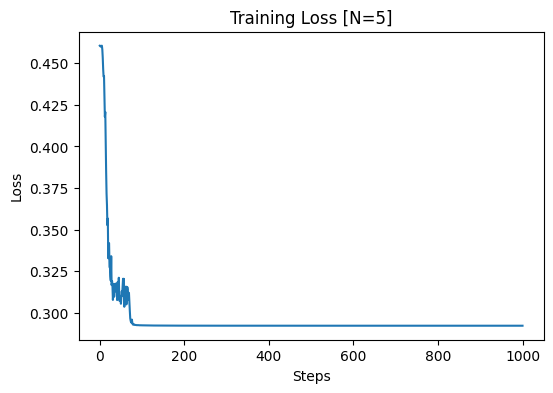

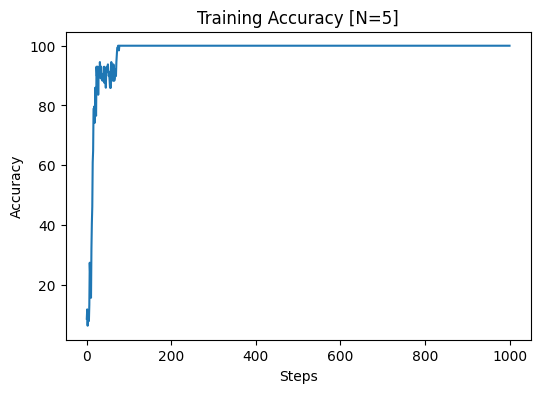

In [25]:
# Plot the losses
plot_loss(losses, title='Training Loss [N=5]', path=results_path + 'training_loss_5_lstm.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy [N=5]', path=results_path + 'training_accuracy_5_lstm.png')

In [26]:
# Test the model
test_accuracies = test(model, input_length=p1[0], config=config, device=device)

# Add accuracies
p3_acc_lstm.append(np.mean(test_accuracies))

Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Finished Testing


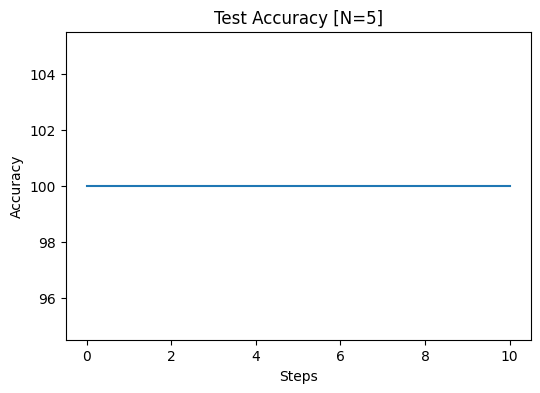

Average test accuracy: 100.00%


In [27]:
# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy [N=5]', path=results_path + 'test_accuracy_5_lstm.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

In [28]:
# Train the model T=10
model, losses, accuracies = train(config, input_length=p1[1], lr=config['lstm_learning_rate'], type='LSTM', device=device)

[step:     0] loss: 0.4602 acc: 15.6250 time: 1547372708


<ipython-input-5-0a8de5faed98>:64: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:    10] loss: 0.4612 acc: 8.5938 time: 1547372709
[step:    20] loss: 0.4613 acc: 8.5938 time: 1547372709
[step:    30] loss: 0.4598 acc: 10.9375 time: 1547372709
[step:    40] loss: 0.4606 acc: 9.3750 time: 1547372709
[step:    50] loss: 0.4598 acc: 11.7188 time: 1547372710
[step:    60] loss: 0.4594 acc: 14.8438 time: 1547372710
[step:    70] loss: 0.4621 acc: 5.4688 time: 1547372710
[step:    80] loss: 0.4615 acc: 6.2500 time: 1547372711
[step:    90] loss: 0.4600 acc: 11.7188 time: 1547372711
[step:   100] loss: 0.4580 acc: 10.1562 time: 1547372711
[step:   110] loss: 0.4498 acc: 24.2188 time: 1547372711
[step:   120] loss: 0.4449 acc: 21.0938 time: 1547372712
[step:   130] loss: 0.4444 acc: 17.1875 time: 1547372712
[step:   140] loss: 0.4316 acc: 35.1562 time: 1547372712
[step:   150] loss: 0.4246 acc: 36.7188 time: 1547372713
[step:   160] loss: 0.4206 acc: 42.9688 time: 1547372713
[step:   170] loss: 0.4008 acc: 48.4375 time: 1547372713
[step:   180] loss: 0.3943 acc: 57.0

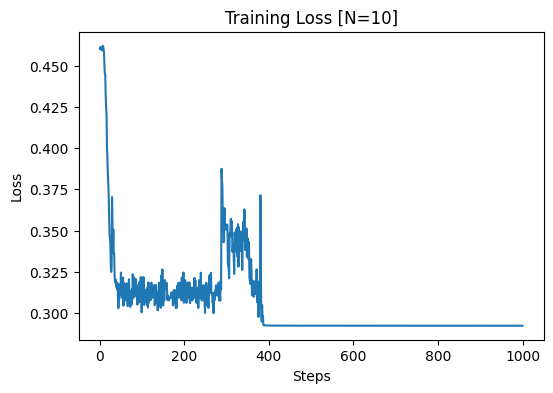

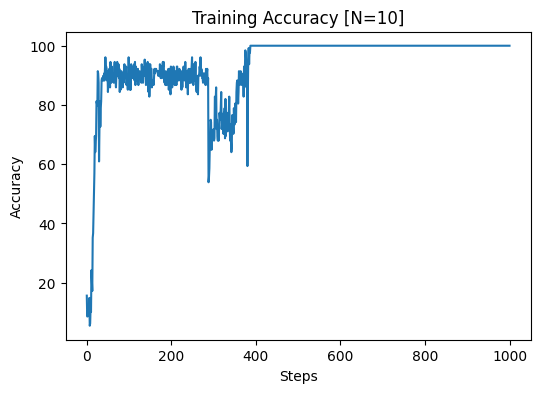

In [29]:
# Plot the losses
plot_loss(losses, title='Training Loss [N=10]', path=results_path + 'training_loss_10_lstm.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy [N=10]', path=results_path + 'training_accuracy_10_lstm.png')

In [30]:
# Test the model
test_accuracies = test(model, input_length=p1[1], config=config, device=device)

# Add accuracies
p3_acc_lstm.append(np.mean(test_accuracies))

Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Finished Testing


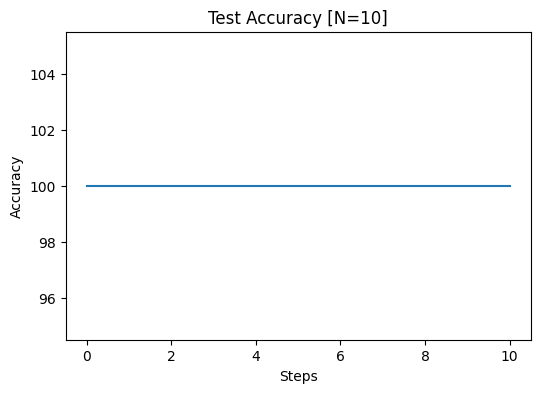

Average test accuracy: 100.00%


In [31]:
# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy [N=10]', path=results_path + 'test_accuracy_10_lstm.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

In [32]:
# Train the model T=15
model, losses, accuracies = train(config, input_length=p1[2], lr=config['lstm_learning_rate'], type='LSTM', device=device)

[step:     0] loss: 0.4606 acc: 8.5938 time: 1547373018


<ipython-input-5-0a8de5faed98>:64: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:    10] loss: 0.4608 acc: 8.5938 time: 1547373018
[step:    20] loss: 0.4614 acc: 5.4688 time: 1547373019
[step:    30] loss: 0.4606 acc: 10.1562 time: 1547373019
[step:    40] loss: 0.4604 acc: 11.7188 time: 1547373019
[step:    50] loss: 0.4605 acc: 11.7188 time: 1547373020
[step:    60] loss: 0.4606 acc: 11.7188 time: 1547373020
[step:    70] loss: 0.4613 acc: 6.2500 time: 1547373021
[step:    80] loss: 0.4603 acc: 12.5000 time: 1547373021
[step:    90] loss: 0.4603 acc: 14.0625 time: 1547373021
[step:   100] loss: 0.4612 acc: 5.4688 time: 1547373022
[step:   110] loss: 0.4597 acc: 9.3750 time: 1547373022
[step:   120] loss: 0.4584 acc: 15.6250 time: 1547373023
[step:   130] loss: 0.4532 acc: 16.4062 time: 1547373023
[step:   140] loss: 0.4496 acc: 17.1875 time: 1547373024
[step:   150] loss: 0.4462 acc: 20.3125 time: 1547373024
[step:   160] loss: 0.4490 acc: 15.6250 time: 1547373025
[step:   170] loss: 0.4356 acc: 34.3750 time: 1547373025
[step:   180] loss: 0.4306 acc: 32.8

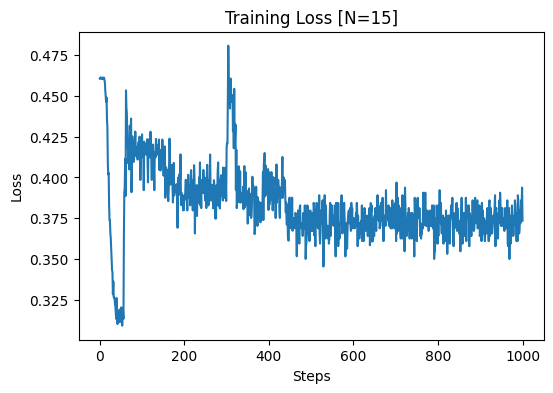

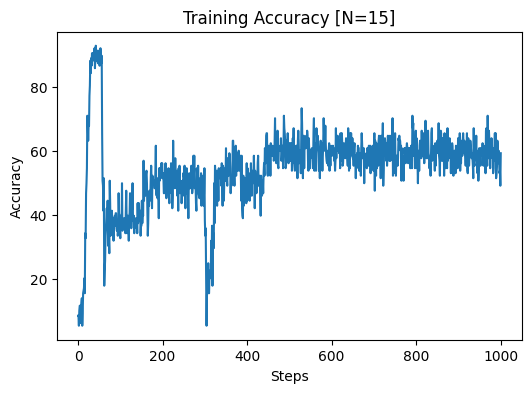

In [33]:
# Plot the losses
plot_loss(losses, title='Training Loss [N=15]', path=results_path + 'training_loss_15_lstm.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy [N=15]', path=results_path + 'training_accuracy_15_lstm.png')

In [34]:
# Test the model
test_accuracies = test(model, input_length=p1[2], config=config, device=device)

# Add accuracies
p3_acc_lstm.append(np.mean(test_accuracies))

Accuracy: 63.2812
Accuracy: 61.7188
Accuracy: 56.2500
Accuracy: 60.9375
Accuracy: 57.8125
Accuracy: 60.9375
Accuracy: 56.2500
Accuracy: 62.5000
Accuracy: 64.0625
Accuracy: 62.5000
Accuracy: 53.9062
Finished Testing


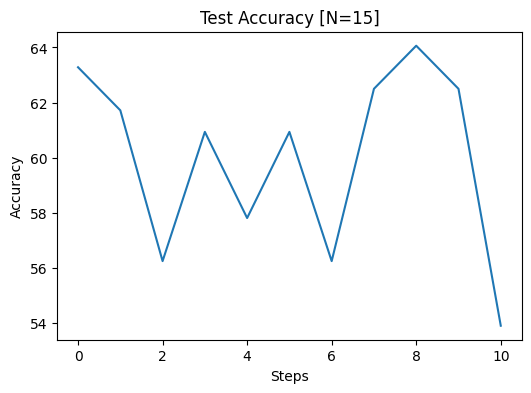

Average test accuracy: 60.01%


In [35]:
# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy [N=15]', path=results_path + 'test_accuracy_15_lstm.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

In [36]:
# Train the model T=20
model, losses, accuracies = train(config, input_length=p1[3], lr=config['lstm_learning_rate'], type='LSTM', device=device)

[step:     0] loss: 0.4607 acc: 12.5000 time: 1547373444


<ipython-input-5-0a8de5faed98>:64: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:    10] loss: 0.4609 acc: 9.3750 time: 1547373445
[step:    20] loss: 0.4604 acc: 11.7188 time: 1547373445
[step:    30] loss: 0.4602 acc: 9.3750 time: 1547373446
[step:    40] loss: 0.4608 acc: 7.8125 time: 1547373447
[step:    50] loss: 0.4604 acc: 12.5000 time: 1547373448
[step:    60] loss: 0.4602 acc: 7.0312 time: 1547373449
[step:    70] loss: 0.4604 acc: 12.5000 time: 1547373449
[step:    80] loss: 0.4602 acc: 10.1562 time: 1547373450
[step:    90] loss: 0.4609 acc: 10.1562 time: 1547373451
[step:   100] loss: 0.4612 acc: 10.1562 time: 1547373451
[step:   110] loss: 0.4603 acc: 10.1562 time: 1547373451
[step:   120] loss: 0.4605 acc: 10.1562 time: 1547373452
[step:   130] loss: 0.4607 acc: 9.3750 time: 1547373452
[step:   140] loss: 0.4602 acc: 8.5938 time: 1547373453
[step:   150] loss: 0.4613 acc: 7.8125 time: 1547373453
[step:   160] loss: 0.4604 acc: 10.9375 time: 1547373454
[step:   170] loss: 0.4608 acc: 9.3750 time: 1547373454
[step:   180] loss: 0.4599 acc: 14.8438

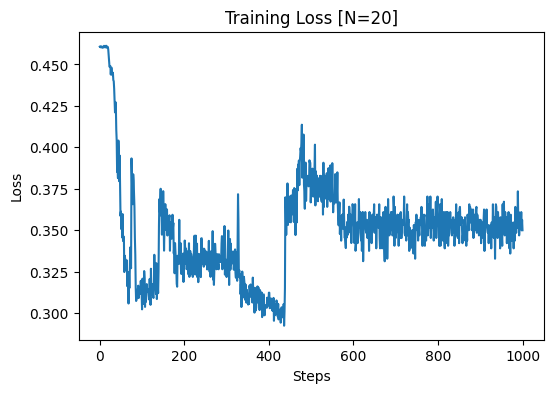

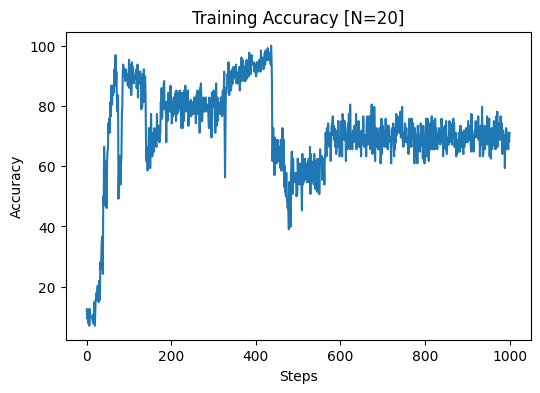

In [37]:
# Plot the losses
plot_loss(losses, title='Training Loss [N=20]', path=results_path + 'training_loss_20_lstm.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy [N=20]', path=results_path + 'training_accuracy_20_lstm.png')

In [38]:
# Test the model
test_accuracies = test(model, input_length=p1[3], config=config, device=device)

# Add accuracies
p3_acc_lstm.append(np.mean(test_accuracies))

Accuracy: 71.0938
Accuracy: 69.5312
Accuracy: 77.3438
Accuracy: 71.8750
Accuracy: 67.1875
Accuracy: 64.8438
Accuracy: 78.1250
Accuracy: 70.3125
Accuracy: 71.0938
Accuracy: 66.4062
Accuracy: 71.0938
Finished Testing


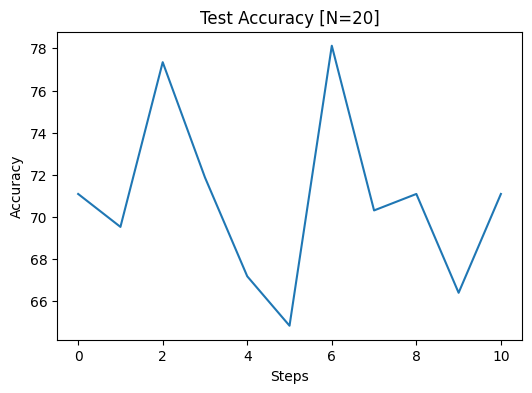

Average test accuracy: 70.81%


In [39]:
# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy [N=20]', path=results_path + 'test_accuracy_20_lstm.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

**Question 1.6: Comparison LSTM & Vanilla RNN**

Write down a comparison with the vanilla RNN and think of reasons for the different behavior on the Palindrome prediction task.

*Convergence speed:*
- LSTM network generally converges faster than the Vanilla RNN during training due to its gating mechanism, which helps mitigate the vanishing gradient problem. The Vanilla RNN is more susceptible to the Vanishing Gradient problem since it's gradients have to be propagated through sevaral learnable layers who's values might become arbitrarily small or large. For both training loops a gradient clipping is used to prevent the models from exploding gradients.

*Performance with longer sequences:*
- Vanilla RNNs: The accuracy tends to decrease, and the loss increases during training with longer sequences due to the vanishing gradient problem. Gradient clipping is used to prevent gradients from exploding, but it does not address the vanishing gradient issue noticable in Vanilla RNNs which prevents the Vanilla RNN to _memorise_ the necessary information from an earlier timestep in order to solve the palindrome task.
- LSTM network: The LSTM also exhibits reduced accuracy with increasing lengths of palindrome sequences. However, in comparison to the Vanilla RNN this is less pronounced. The network needs to learn parameters to preserve the right amount of information from a very early stage onwards, which can be challenging.

*LSTM's struggle with updating information:*
- It is possible that the LSTM network struggles to learn to update the right information and not remove relevant signals, especially when dealing with longer sequences. This might be due to the difficulty in optimizing the complex interactions between the input, forget, and output gates.

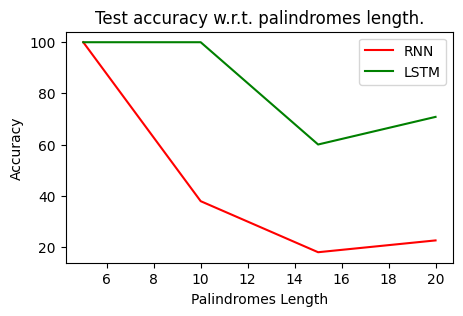

In [45]:
plt.figure(figsize=(5,3))

plt.title('Test accuracy w.r.t. palindromes length.')
# Plot RNN avg. test acc
plt.plot(p1, p2_acc_rnn, color='red', label='RNN')
# Plot LSTM avg. test acc
plt.plot(p1, p3_acc_lstm, color='green', label='LSTM')

plt.xlabel('Palindromes Length')
plt.ylabel('Accuracy')
plt.legend()
plt.show()